Calculating Energy Efficiency for an IRS-Assisted Wireless Network.
1. Using a 3D environment to model Base Station, IRS and Users.
2. Implementing on a 2 User system.
3. Starting with a Double-IRS Assisted Network, comparing energy efficiency with varying transmit power for both Ideal and Practical Models.
4. Shifting to a Single IRS Assisted Network and comparing energy efficiency with varying transmit power for both Ideal and Practical Models.
5. We have performed the comparison keeping in mind all three quantization bits, and considering element sharing to be true for all scenarios. 

In [36]:
# Importing all libraries

import numpy as np 
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from Functions import *

In [37]:
#============== System parameters
'''
Defining Parameters
    Nt = Number of transmit antennas (SISO = 1)
    K = Number of Users
    BW = Bandwidth
    NF = Noise Floor
    ALPHA = PLE for indirect link (IRS-1)
    BETA = PLE for indirect link (IRS-2)
    ZETA = PLE for direct link 
    wn = efficiency of transmit power amplifier
    Pb = Power dissipated by BS
    Pu = Power dissipated by User
    loc_U = User positions
    m = Nakagami Shape parameter (m > 0, m = 1 corresponds to Rayleigh fading)
    omega = 1.0  Nakagami Spread parameter (omega > 0)
    Ns_max = Total number of IRS elements in a single IRS

'''
Nt = 1
K = 2
# gamma = db2pow(20)
f = 2.4e9
c = 3e8
Lambda = c/f
halfLambda = 0.5*Lambda
quarterLambda = 0.25*Lambda
BW = 20e6
NF = 10
noise = -133 # -174+10*np.log10(BW) + NF

# Network Parameters
GRID_RADIUS = 1000
BASE_STATION_POSITION = (0, 0, 20)
TRANSMIT_POWER_WATTS = 0.1 #in watts
NUM_SIMULATIONS = 10000
dThreshold = GRID_RADIUS / 40

# Fading Paramters
FADING_STD_MEAN = 0
FADING_STD_DEV = 3
m = 1
omega = np.sqrt(0.5)

# Path Loss Parameters
ALPHA = 2.2 #path loss exponent (indirect - IRS 1)
BETA = 3.8 #path loss exponent  (indirect - IRS 1)
ZETA = 3.8 #path loss exponent  (direct)

# IRS Positions
IRS_POSITION_1 = (300, 400, 10)
IRS_POSITION_2 = (300, -400, 10)
nIRSrow = 10
nIRScol = nIRSrow
Ns = nIRScol * nIRSrow


# Power consumption params
wn = 0.5
Pb = 10 # in dBw
Pu = 10 # 10 in dBm

#Practical phase shift model paramters
a = 1.6
phi = 0.43 * np.pi
B_min = 0.2

Generating Positions for IRS, Users, BS

In [38]:
xt, yt, zt = BASE_STATION_POSITION
xs_1, ys_1, zs_1 = IRS_POSITION_1
xs_2, ys_2, zs_2 = IRS_POSITION_2
USER_POS = generate_user_positions_3D(K, GRID_RADIUS)

loc_T = np.array([BASE_STATION_POSITION])
loc_U = USER_POS

# ---------------------------------------------------------Calculating distances for IRS-----------------------------------------------------------------------------------
        
irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
loc_S_1 = irs_coords_1
        # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
        # print()
        
irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
loc_S_2 = irs_coords_2
        # print('IRS 2 elements coordinates:'"\n", loc_S_2) 
        # print()
        
dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
        
        # Reshapiing the distance from antennas/BS to user
dTU = dTU.reshape(Nt,K)
        # Compute row-wise averages
dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
dSU_1 = dSU_1.reshape(1,K)
        # Compute the sum of elements in each row
dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
dTS_1 = np.mean(dTS_1)
        # Compute row-wise averages
dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
dSU_2 = dSU_2.reshape(1,K)
        # Compute the sum of elements in each row
dTS_2 = np.mean(dTS_2, axis=1)
        # Compute the average of row sums
dTS_2 = np.mean(dTS_2)


Plotting Network

User positions:
 [[ 372.07875089  -56.8918319     0.        ]
 [-900.39297788  411.93647889    0.        ]]
BS position:
 (0, 0, 20)
IRS-1 position:
 (300, 400, 10)
IRS-2 position:
 (300, -400, 10)


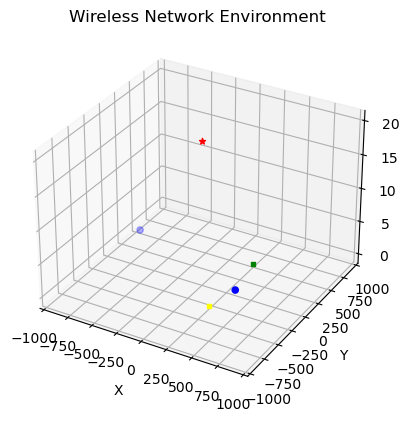

In [39]:

fig = plt.figure()
ax = plt.axes(projection ="3d")
ax.scatter3D(USER_POS[:, 0], USER_POS[:, 1], color='blue', marker='o', label='Users')
ax.scatter(xt, yt, zt, color='red', marker='*', label='Base Station')
plt.scatter(xs_1, ys_1, zs_1, color='green', marker='s', label='IRS_1')
plt.scatter(xs_2, ys_2, zs_2, color='yellow', marker='s', label='IRS_2')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.axis([-1000,1000,-1000,1000])
ax.set_title('Wireless Network Environment')
# ax.legend()
ax.grid(True)

print('User positions:'"\n" , USER_POS)
print('BS position:'"\n" , BASE_STATION_POSITION)
print('IRS-1 position:'"\n" , IRS_POSITION_1)
print('IRS-2 position:'"\n" , IRS_POSITION_2)




Generating Channels

In [40]:

h_dk_3d = np.zeros((NUM_SIMULATIONS,K,1), dtype= np.complex128)
h_rk1_3d = np.zeros((NUM_SIMULATIONS,Ns,K), dtype= np.complex128)
h_rk1_h_3d = np.zeros((NUM_SIMULATIONS,K,Ns), dtype= np.complex128)
G1_3d = np.zeros((NUM_SIMULATIONS,Ns,1), dtype= np.complex128)
h_rk2_3d = np.zeros((NUM_SIMULATIONS,Ns,K), dtype= np.complex128)
h_rk2_h_3d = np.zeros((NUM_SIMULATIONS,K,Ns), dtype= np.complex128) 
G2_3d = np.zeros((NUM_SIMULATIONS,Ns,1), dtype= np.complex128)



# Perform simulations
for i in range(NUM_SIMULATIONS):

    # Generate the Rayleigh Fading Channel for each user (h_dk)
    h_dk = np.zeros((K,1))
    h_dk = np.array(generate_rayleigh_fading_channel(K,FADING_STD_MEAN,FADING_STD_DEV))
    for m in range(K):
        if(dTU[:,m] < dThreshold):
            h_dk[m] = 0
        else:
            h_dk[m] = h_dk[m]
    h_dk = np.reshape(h_dk ,(K,1))
    h_dk_3d[i] = h_dk
    
    # Generate the Nakagami Channel from each user to the IRS-1 (h_rk1)
    fading = []
    for user in range(K):
        fading.append(generate_nakagami_samples(m,omega,Ns)) 
    h_rk1 = fading
    h_rk1 = np.reshape(h_rk1,(Ns,K))
    h_rk1_transpose = np.transpose(h_rk1)
    h_rk1_h = np.conj(h_rk1_transpose)
    h_rk1_3d[i] = h_rk1
    h_rk1_h_3d[i] = h_rk1_h


    # Generate the Nakagami Channel from each user to the IRS-2 (h_rk2)
    fading = []
    for user in range(K):
        fading.append(generate_nakagami_samples(m,omega,Ns)) 
    h_rk2 = fading
    h_rk2 = np.reshape(h_rk2,(Ns,K))
    h_rk2_transpose = np.transpose(h_rk2)
    h_rk2_h = np.conj(h_rk2_transpose)
    h_rk2_3d[i] = h_rk2
    h_rk2_h_3d[i] = h_rk2_h

    # Generate the Nakagami Channel from base_station to the IRS-1 (G1)
    G1 = generate_nakagami_samples(m,omega,Ns) 
    G1 = np.reshape(G1,(Ns,1))
    G1_3d[i] = G1

    # Generate the Nakagami Channel from base_station to the IRS-2 (G2)
    G2 = generate_nakagami_samples(m,omega,Ns)
    G2 = np.reshape(G2,(Ns,1))
    G2_3d[i] = G2

print('Size of hdk3d', np.shape(h_dk_3d))
print('Size of hrk3d', np.shape(h_rk1_3d))
print('Size of hrkh3d', np.shape(h_rk1_h_3d))
print('Size of g3d', np.shape(G1_3d))



Size of hdk3d (10000, 2, 1)
Size of hrk3d (10000, 100, 2)
Size of hrkh3d (10000, 2, 100)
Size of g3d (10000, 100, 1)


Simulations for Ideal Continuos Case, Double IRS

In [41]:
RATE_THRESHOLD = 10
qB = np.arange(1,4,1)
Pt = np.arange(0, 47, 2) # in dBm



arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))

# Initialize an empty dictionary to store the results
results_dict_1 = {}
results_dict_2 = {}
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 2,3,4 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

# quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
for B in qB:

    average_energy_efficiency_1 = []

    for T in Pt:
        TRANSMIT_POWER_WATTS = dBm2pow(T)

        
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values for current Ns value-----------------------------------------------------------------------------------
        # Direct Link
        h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

        # BS to IRS
        G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        G2_ns_values = [G2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # IRS to Users
        h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk2_ns_values = [h_rk2_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
        h_rk2_h_ns_values = [h_rk2_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        
        # Initialize list to store individual outage probabilities
        energy_efficiency = []
        # Initialize sum-rates for this case
        sum_rate = []

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------RUNNING SIMULATIONS---------------------------------------------------------------------------------------------------------------------
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s] # Shape: (K, 1)
            h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
            h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
            G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

            h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
            h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
            G_2 = G2_ns_values[s]  # Shape: (Ns, 1)
            
            theta_1 = theta_matrix_ideal(1, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, quantized_theta_set= None)
            theta_2 = theta_matrix_ideal(1, h_dk= h_dk , h_rk= h_rk2, g= G_2, K= K, Ns= Ns, quantized_theta_set= None)


            results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)
            results_array_2 = prod_matrix(theta_2, h_rk2_h, G_2, K, Ns)

        # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
            arr_link_budget = np.zeros((K,1))
            for m in range (K):
                arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((h_dk[m]/np.sqrt(dTU[:,m]**ZETA)) + ((results_array_1[m]/np.sqrt((dSU_1[:,m]**ALPHA)*(dTS_1**ALPHA)))  + (results_array_2[m]/np.sqrt((dSU_1[:,m]**BETA)*(dTS_2**BETA))))))
                arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
            arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))
            # print('For N:', Ns, 'Sum rate:', arr_sumrate_disc) 

            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_21 = compute_power_consumption_at_ris(B, Ns)
            power_22 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_21 + power_22 + power_3

            ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
            energy_efficiency.append(ee/10e6)
        average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
        average_energy_efficiency_1.append(average_energy_efficiencies_1)


    results_dict_2[B] = average_energy_efficiency_1

print('done')
print(qB)



done
[1 2 3]


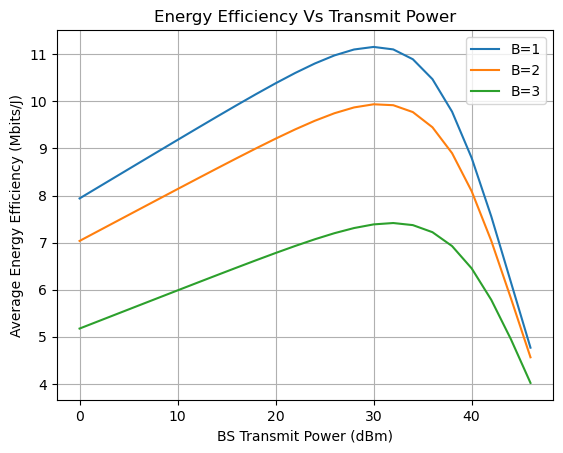

In [42]:
# Plot the graph for each value of N
for B, average_energy_efficiency_1 in results_dict_2.items():
    plt.plot(Pt, average_energy_efficiency_1, label=f'B={B}')

plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('BS Transmit Power (dBm)')
plt.title('Energy Efficiency Vs Transmit Power')
plt.legend()
plt.grid(True)
plt.show()

# # Plot the graph for each value of N
# for B, sum_rates_1 in results_dict_1.items():
#     plt.plot(T, sum_rates_1, label=f'B={B}')

# plt.ylabel('Sum rate')
# plt.xlabel('BS Transmit Power (dBm)')
# plt.title('Sum Rates Vs Transmit Power')
# plt.legend()
# plt.grid(True)
# plt.show()

Simulations for Practical Discrete Case, Double IRS

In [43]:
RATE_THRESHOLD = 10
qB = np.arange(1,4,1)
Pt = np.arange(0, 47, 2) # in dBm



arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))

# Initialize an empty dictionary to store the results
results_dict_1 = {}
results_dict_2 = {}
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 2,3,4 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

# quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
for B in qB:

    average_energy_efficiency_1 = []
    # Create a set of quantized theta values
    quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    print('Quantized_theta_set: ',"\n", (quantized_theta_set))

    for T in Pt:
        TRANSMIT_POWER_WATTS = dBm2pow(T)

        
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values for current Ns value-----------------------------------------------------------------------------------
        # Direct Link
        h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

        # BS to IRS
        G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        G2_ns_values = [G2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # IRS to Users
        h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk2_ns_values = [h_rk2_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
        h_rk2_h_ns_values = [h_rk2_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        
        # Initialize list to store individual outage probabilities
        energy_efficiency = []
        # Initialize sum-rates for this case
        sum_rate = []

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------RUNNING SIMULATIONS---------------------------------------------------------------------------------------------------------------------
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s] # Shape: (K, 1)
            h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
            h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
            G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

            h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
            h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
            G_2 = G2_ns_values[s]  # Shape: (Ns, 1)
            
            theta_1 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set)
            theta_2 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk2, g= G_2, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set )

            results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)
            results_array_2 = prod_matrix(theta_2, h_rk2_h, G_2, K, Ns)
        # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
            arr_link_budget = np.zeros((K,1))
            for m in range (K):
                arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((h_dk[m]/np.sqrt(dTU[:,m]**ZETA)) + ((results_array_1[m]/np.sqrt((dSU_1[:,m]**ALPHA)*(dTS_1**ALPHA)))  + (results_array_2[m]/np.sqrt((dSU_1[:,m]**BETA)*(dTS_2**BETA))))))
                arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
            arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))

            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_21 = compute_power_consumption_at_ris(B, Ns)
            power_22 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_21 + power_22 + power_3

            ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
            energy_efficiency.append(ee/10e6)
        average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
        average_energy_efficiency_1.append(average_energy_efficiencies_1)


    results_dict_2[B] = average_energy_efficiency_1

print('done')
print(qB)



Quantized_theta_set:  
 [-3.14159265  0.        ]
Quantized_theta_set:  
 [-3.14159265 -1.57079633  0.          1.57079633]


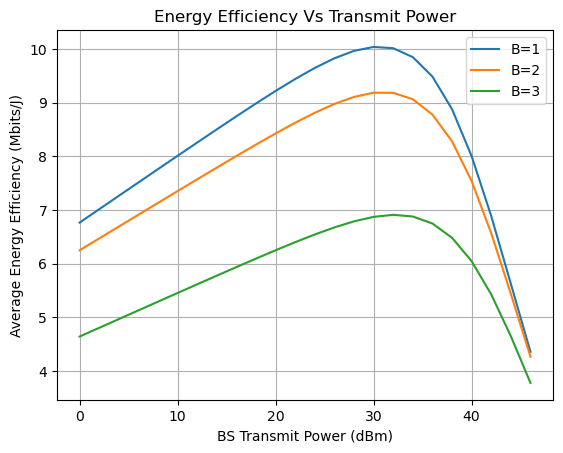

In [ ]:
# Plot the graph for each value of N
for B, average_energy_efficiency_1 in results_dict_2.items():
    plt.plot(Pt, average_energy_efficiency_1, label=f'B={B}')

plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('BS Transmit Power (dBm)')
plt.title('Energy Efficiency Vs Transmit Power')
plt.legend()
plt.grid(True)
plt.show()

# # Plot the graph for each value of N
# for B, sum_rates_1 in results_dict_1.items():
#     plt.plot(T, sum_rates_1, label=f'B={B}')

# plt.ylabel('Sum rate')
# plt.xlabel('BS Transmit Power (dBm)')
# plt.title('Sum Rates Vs Transmit Power')
# plt.legend()
# plt.grid(True)
# plt.show()

# SINGLE IRS CASE

User positions:
 [[-530.2453714  -273.76205411    0.        ]
 [ 481.23704111 -163.5199784     0.        ]]
BS position:
 (0, 0, 20)
IRS-1 position:
 (300, 400, 10)


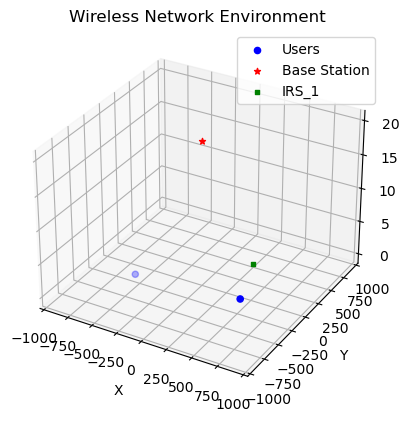

In [ ]:

xt, yt, zt = BASE_STATION_POSITION
xs_1, ys_1, zs_1 = IRS_POSITION_1

fig = plt.figure()
ax = plt.axes(projection ="3d")
ax.scatter3D(USER_POS[:, 0], USER_POS[:, 1], color='blue', marker='o', label='Users')
ax.scatter(xt, yt, zt, color='red', marker='*', label='Base Station')
plt.scatter(xs_1, ys_1, zs_1, color='green', marker='s', label='IRS_1')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.axis([-1000,1000,-1000,1000])
ax.set_title('Wireless Network Environment')
plt.legend()
# ax.legend()
ax.grid(True)

print('User positions:'"\n" , USER_POS)
print('BS position:'"\n" , BASE_STATION_POSITION)
print('IRS-1 position:'"\n" , IRS_POSITION_1)

loc_T = np.array([BASE_STATION_POSITION])
loc_U = USER_POS



In [ ]:
h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

# BS to IRS
G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

# IRS to Users
h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)


Simulations for Ideal Continuos Case, Single IRS

In [ ]:
RATE_THRESHOLD = 10
qB = np.arange(1,4,1)
Pt = np.arange(0, 47, 2) # in dBm



arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))

# Initialize an empty dictionary to store the results
results_dict_1 = {}
results_dict_2 = {}
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 2,3,4 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

# quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
for B in qB:

    average_energy_efficiency_1 = []

    for T in Pt:
        TRANSMIT_POWER_WATTS = dBm2pow(T)

        
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values for current Ns value-----------------------------------------------------------------------------------
        # Direct Link
        h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

        # BS to IRS
        G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        G2_ns_values = [G2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # IRS to Users
        h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk2_ns_values = [h_rk2_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
        h_rk2_h_ns_values = [h_rk2_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        
        # Initialize list to store individual outage probabilities
        energy_efficiency = []
        # Initialize sum-rates for this case
        sum_rate = []

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------RUNNING SIMULATIONS---------------------------------------------------------------------------------------------------------------------
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s] # Shape: (K, 1)
            h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
            h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
            G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

            h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
            h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
            G_2 = G2_ns_values[s]  # Shape: (Ns, 1)
            
            theta_1 = theta_matrix_ideal(1, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, quantized_theta_set= None)
            results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)

        # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
            arr_link_budget = np.zeros((K,1))
            for m in range (K):
                arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((h_dk[m]/np.sqrt(dTU[:,m]**ZETA)) + ((results_array_1[m]/np.sqrt((dSU_1[:,m]**ALPHA)*(dTS_1**ALPHA))))))
                arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
            arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))

            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_21 = compute_power_consumption_at_ris(B, Ns)
            power_22 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_21 + power_22 + power_3

            ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
            energy_efficiency.append(ee/10e6)
        average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
        average_energy_efficiency_1.append(average_energy_efficiencies_1)


    results_dict_2[B] = average_energy_efficiency_1

print('done')
print(qB)



done
[1 2 3]


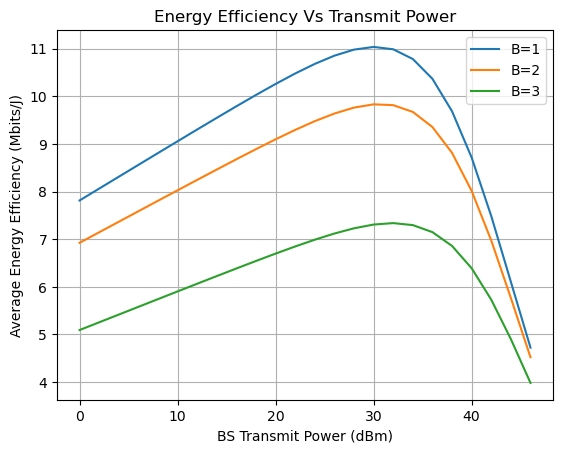

In [ ]:
# Plot the graph for each value of N
for B, average_energy_efficiency_1 in results_dict_2.items():
    plt.plot(Pt, average_energy_efficiency_1, label=f'B={B}')

plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('BS Transmit Power (dBm)')
plt.title('Energy Efficiency Vs Transmit Power')
plt.legend()
plt.grid(True)
plt.show()

# # Plot the graph for each value of N
# for B, sum_rates_1 in results_dict_1.items():
#     plt.plot(T, sum_rates_1, label=f'B={B}')

# plt.ylabel('Sum rate')
# plt.xlabel('BS Transmit Power (dBm)')
# plt.title('Sum Rates Vs Transmit Power')
# plt.legend()
# plt.grid(True)
# plt.show()

Simulations for Practical Discrete Case, Single IRS

In [ ]:
RATE_THRESHOLD = 10
qB = np.arange(1,4,1)
Pt = np.arange(0, 47, 2) # in dBm



arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))

# Initialize an empty dictionary to store the results
results_dict_1 = {}
results_dict_2 = {}
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 2,3,4 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

# quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
for B in qB:

    average_energy_efficiency_1 = []

    for T in Pt:
        TRANSMIT_POWER_WATTS = dBm2pow(T)

        
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values for current Ns value-----------------------------------------------------------------------------------
        # Direct Link
        h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

        # BS to IRS
        G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        G2_ns_values = [G2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # IRS to Users
        h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk2_ns_values = [h_rk2_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
        h_rk2_h_ns_values = [h_rk2_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        
        # Initialize list to store individual outage probabilities
        energy_efficiency = []
        # Initialize sum-rates for this case
        sum_rate = []

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------RUNNING SIMULATIONS---------------------------------------------------------------------------------------------------------------------
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s] # Shape: (K, 1)
            h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
            h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
            G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

            theta_1 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set)
            results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)
        # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
            arr_link_budget = np.zeros((K,1))
            for m in range (K):
                arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((h_dk[m]/np.sqrt(dTU[:,m]**ZETA)) + ((results_array_1[m]/np.sqrt((dSU_1[:,m]**ALPHA)*(dTS_1**ALPHA))))))
                arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
            arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))

            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_21 = compute_power_consumption_at_ris(B, Ns)
            power_22 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_21 + power_22 + power_3

            ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
            energy_efficiency.append(ee/10e6)
        average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
        average_energy_efficiency_1.append(average_energy_efficiencies_1)


    results_dict_2[B] = average_energy_efficiency_1

print('done')
print(qB)



done
[1 2 3]


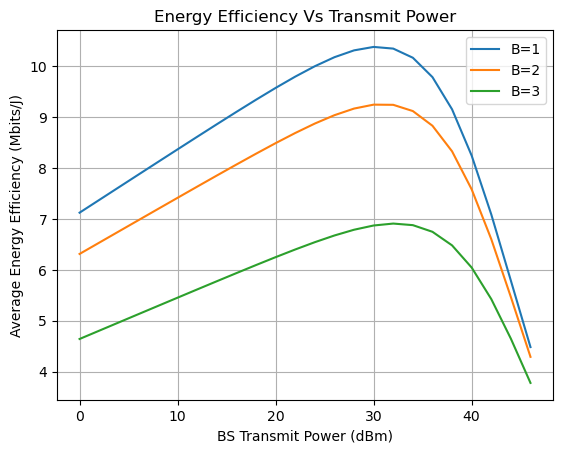

In [ ]:
# Plot the graph for each value of N
for B, average_energy_efficiency_1 in results_dict_2.items():
    plt.plot(Pt, average_energy_efficiency_1, label=f'B={B}')

plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('BS Transmit Power (dBm)')
plt.title('Energy Efficiency Vs Transmit Power')
plt.legend()
plt.grid(True)
plt.show()

# # Plot the graph for each value of N
# for B, sum_rates_1 in results_dict_1.items():
#     plt.plot(T, sum_rates_1, label=f'B={B}')

# plt.ylabel('Sum rate')
# plt.xlabel('BS Transmit Power (dBm)')
# plt.title('Sum Rates Vs Transmit Power')
# plt.legend()
# plt.grid(True)
# plt.show()